# Chapter 7 - Working with Text Data

In [57]:
!sudo apt install tree
!pip install mglearn nltk spacy
!python -m spacy download en

     |████████████████████████████████| 12.0 MB 5.5 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [71]:
import matplotlib.pyplot as plt
import mglearn
import nltk
import numpy as np
import re
import sklearn
import spacy


from sklearn.datasets import load_files
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline

## 7.1 Types of Data Represented as Strings

1. Categorical data
2. Free strings that can be semantically mapped to categories
3. Structured string data
4. Text data

## 7.2 Example Application: Sentiment Analysis of Movie Reviews

In [3]:
!wget -nc http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz -P data
!tar xzf data/aclImdb_v1.tar.gz --skip-old-files -C data

--2021-12-20 03:09:13--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘data/aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  24.0MB/s    in 3.3s    

2021-12-20 03:09:17 (24.0 MB/s) - ‘data/aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [4]:
!tree -dL 2 data/aclImdb

data/aclImdb
├── test
│   ├── neg
│   └── pos
└── train
    ├── neg
    ├── pos
    └── unsup

7 directories


In [5]:
!rm -r data/aclImdb/train/unsup

In [6]:
!tree -dL 2 data/aclImdb

data/aclImdb
├── test
│   ├── neg
│   └── pos
└── train
    ├── neg
    └── pos

6 directories


In [7]:
reviews_train = load_files('data/aclImdb/train/')

# load_files returns a bunch, containing training texts and training labels
text_train, y_train = reviews_train.data, reviews_train.target

print('type of text_train: {}'.format(type(text_train)))
print('length of text_train: {}'.format(len(text_train)))
print('text_train[6]:\n{}'.format(text_train[6]))

type of text_train: <class 'list'>
length of text_train: 25000
text_train[6]:
b"This movie has a special way of telling the story, at first i found it rather odd as it jumped through time and I had no idea whats happening.<br /><br />Anyway the story line was although simple, but still very real and touching. You met someone the first time, you fell in love completely, but broke up at last and promoted a deadly agony. Who hasn't go through this? but we will never forget this kind of pain in our life. <br /><br />I would say i am rather touched as two actor has shown great performance in showing the love between the characters. I just wish that the story could be a happy ending."


In [8]:
text_train = [doc.replace(b'<br />', b' ') for doc in text_train]

In [9]:
print('Samples per class (training): {}'.format(np.bincount(y_train)))

Samples per class (training): [12500 12500]


In [10]:
reviews_test = load_files('data/aclImdb/test/')
text_test, y_test = reviews_test.data, reviews_test.target

print('Number of documents in test data: {}'.format(len(text_test)))
print('Samples per class (training): {}'.format(np.bincount(y_test)))

text_test = [doc.replace(b'<br />', b' ') for doc in text_test]

Number of documents in test data: 25000
Samples per class (training): [12500 12500]


## 7.3 Representing Text Data as a Bag of Words

1. *Tokenisation.* Split each document into the words that appear in it (called *tokens*), for example by splitting them on whitespace and punctuation.

2. *Vocabulary building*. Collect a vocabulary of all words that appear in any of the documents, and number them (say, in alphabetical order).

3. *Encoding*. For each document, count how often each of the words in the vocabulary appear in this document.

### 7.3.1 Applying Bag-of-Words to a Toy Dataset

In [11]:
bards_words = ['The fool doth think he is wise,',
               'but the wise man know himself to be a fool']

In [12]:
vect = CountVectorizer()
vect.fit(bards_words)

CountVectorizer()

In [13]:
print('Vocabulary size: {}'.format(len(vect.vocabulary_)))
print('Vocabulary content:\n {}'.format(vect.vocabulary_))

Vocabulary size: 13
Vocabulary content:
 {'the': 9, 'fool': 3, 'doth': 2, 'think': 10, 'he': 4, 'is': 6, 'wise': 12, 'but': 1, 'man': 8, 'know': 7, 'himself': 5, 'to': 11, 'be': 0}


In [14]:
bag_of_words = vect.transform(bards_words)
print('bag_of_words: {}'.format(repr(bag_of_words)))

bag_of_words: <2x13 sparse matrix of type '<class 'numpy.int64'>'
	with 16 stored elements in Compressed Sparse Row format>


In [15]:
print('Dense representation of bag_of_words:\n{}'.format(bag_of_words.toarray()))

Dense representation of bag_of_words:
[[0 0 1 1 1 0 1 0 0 1 1 0 1]
 [1 1 0 1 0 1 0 1 1 1 0 1 1]]


### 7.3.2 Bag-of-Words for Movie Reviews

In [16]:
vect = CountVectorizer().fit(text_train)
X_train = vect.transform(text_train)
print('X_train:\n{}'.format(repr(X_train)))

X_train:
<25000x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 3431196 stored elements in Compressed Sparse Row format>


In [17]:
feature_names = vect.get_feature_names_out()
print('Number of features: {}'.format(len(feature_names)))
print('First 20 features:\n{}'.format(feature_names[: 20]))
print('Features 20010 to 20030:\n{}'.format(feature_names[20010: 20030]))
print('Every 2000th feature:\n{}'.format(feature_names[::2000]))

Number of features: 74849
First 20 features:
['00' '000' '0000000000001' '00001' '00015' '000s' '001' '003830' '006'
 '007' '0079' '0080' '0083' '0093638' '00am' '00pm' '00s' '01' '01pm' '02']
Features 20010 to 20030:
['dratted' 'draub' 'draught' 'draughts' 'draughtswoman' 'draw' 'drawback'
 'drawbacks' 'drawer' 'drawers' 'drawing' 'drawings' 'drawl' 'drawled'
 'drawling' 'drawn' 'draws' 'draza' 'dre' 'drea']
Every 2000th feature:
['00' 'aesir' 'aquarian' 'barking' 'blustering' 'bête' 'chicanery'
 'condensing' 'cunning' 'detox' 'draper' 'enshrined' 'favorit' 'freezer'
 'goldman' 'hasan' 'huitieme' 'intelligible' 'kantrowitz' 'lawful' 'maars'
 'megalunged' 'mostey' 'norrland' 'padilla' 'pincher' 'promisingly'
 'receptionist' 'rivals' 'schnaas' 'shunning' 'sparse' 'subset'
 'temptations' 'treatises' 'unproven' 'walkman' 'xylophonist']


In [26]:
scores = cross_val_score(LogisticRegression(max_iter=1000, n_jobs=-1), X_train, y_train, cv=5, n_jobs=-1)
print('Mean cross-validation accuracy: {:.2f}'.format(np.mean(scores)))

Mean cross-validation accuracy: 0.88


In [27]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10 ,100]}

grid = GridSearchCV(LogisticRegression(max_iter=1000, n_jobs=-1), param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print('Best cross-validation score: {:.2f}'.format(grid.best_score_))
print('Best parameters: {}'.format(grid.best_params_))

Best cross-validation score: 0.89
Best parameters: {'C': 0.1}


In [28]:
X_test = vect.transform(text_test)
print('Test score: {:.2f}'.format(grid.score(X_test, y_test)))

Test score: 0.88


In [29]:
vect = CountVectorizer(min_df=5).fit(text_train)
X_train = vect.transform(text_train)
print('X_train with min_df: {}'.format(repr(X_train)))

X_train with min_df: <25000x27271 sparse matrix of type '<class 'numpy.int64'>'
	with 3354014 stored elements in Compressed Sparse Row format>


In [33]:
feature_names = vect.get_feature_names_out()

print('First 50 features:\n{}'.format(feature_names[:50]))
print('Features 20010 to 20030:\n{}'.format(feature_names[20010:20030]))
print('Every 700th feature:\n{}'.format(feature_names[::700]))

First 50 features:
['00' '000' '007' '00s' '01' '02' '03' '04' '05' '06' '07' '08' '09' '10'
 '100' '1000' '100th' '101' '102' '103' '104' '105' '107' '108' '10s'
 '10th' '11' '110' '112' '116' '117' '11th' '12' '120' '12th' '13' '135'
 '13th' '14' '140' '14th' '15' '150' '15th' '16' '160' '1600' '16mm' '16s'
 '16th']
Features 20010 to 20030:
['repentance' 'repercussions' 'repertoire' 'repetition' 'repetitions'
 'repetitious' 'repetitive' 'rephrase' 'replace' 'replaced' 'replacement'
 'replaces' 'replacing' 'replay' 'replayable' 'replayed' 'replaying'
 'replays' 'replete' 'replica']
Every 700th feature:
['00' 'affections' 'appropriately' 'barbra' 'blurbs' 'butchered' 'cheese'
 'commitment' 'courts' 'deconstructed' 'disgraceful' 'dvds' 'eschews'
 'fell' 'freezer' 'goriest' 'hauser' 'hungary' 'insinuate' 'juggle'
 'leering' 'maelstrom' 'messiah' 'music' 'occasional' 'parking'
 'pleasantville' 'pronunciation' 'recipient' 'reviews' 'sas' 'shea'
 'sneers' 'steiger' 'swastika' 'thrusting' 't

In [31]:
grid = GridSearchCV(LogisticRegression(max_iter=1000, n_jobs=-1), param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print('Best cross-validation score: {:.2f}'.format(grid.best_score_))

Best cross-validation score: 0.89


## 7.4 Stopwords

In [34]:
print('Number of stop words: {}'.format(len(ENGLISH_STOP_WORDS)))
print('Every 10th stop word:\n{}'.format(list(ENGLISH_STOP_WORDS)[::10]))

Number of stop words: 318
Every 10th stop word:
['anywhere', 'thereby', 'nowhere', 'afterwards', 'what', 'hereby', 'this', 'herself', 'between', 'therefore', 'none', 'seeming', 'its', 'might', 'thereafter', 'himself', 'go', 'always', 'should', 'towards', 'of', 'inc', 'thence', 'onto', 'meanwhile', 'each', 'these', 'couldnt', 'whom', 'latter', 'see', 'please']


In [35]:
# specifying stop_words='english' uses the built-in list.
# we could also augment it and pass our own
vect = CountVectorizer(min_df=5, stop_words='english').fit(text_train)
X_train = vect.transform(text_train)
print('X_train with stop words:\n{}'.format(repr(X_train)))

X_train with stop words:
<25000x26966 sparse matrix of type '<class 'numpy.int64'>'
	with 2149958 stored elements in Compressed Sparse Row format>


In [36]:
grid = GridSearchCV(LogisticRegression(max_iter=1000, n_jobs=-1), param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print('Best cross-validation score: {:.2f}'.format(grid.best_score_))

Best cross-validation score: 0.88


## 7.5 Rescaling the Data with tf-idf

$tfidf(w,d)=tf*log(\frac {N+1} {N_{w}+1})+1$

Where:

$N$ is the number of documents in the training set.

$N_{w}$ is the number of documents in the training set that the word $w$ appears in.

$tf$ (the term frequency) is the number of times that the word $w$ appears in the query document $d$ (the document you want to transform or encode).

In [39]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression(max_iter=1000, n_jobs=-1))
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(text_train, y_train)
print('Best cross-validation score: {:.2f}'.format(grid.best_score_))

Best cross-validation score: 0.89


In [40]:
vectorizer = grid.best_estimator_.named_steps['tfidfvectorizer']

# transform the training data
X_train = vectorizer.transform(text_train)

# find maximum value for each of the features over the dataset
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()

# get feature names
feature_names = np.array(vectorizer.get_feature_names())

print('Features with lowest tfidf:\n{}'.format(feature_names[sorted_by_tfidf[:20]]))
print('Features with highest tfidf:\n{}'.format(feature_names[sorted_by_tfidf[-20:]]))

Features with lowest tfidf:
['suplexes' 'gauche' 'hypocrites' 'oncoming' 'songwriting' 'galadriel'
 'emerald' 'mclaughlin' 'sylvain' 'oversee' 'cataclysmic' 'pressuring'
 'uphold' 'thieving' 'inconsiderate' 'ware' 'denim' 'reverting' 'booed'
 'spacious']
Features with highest tfidf:
['gadget' 'sucks' 'zatoichi' 'demons' 'lennon' 'bye' 'dev' 'weller'
 'sasquatch' 'botched' 'xica' 'darkman' 'woo' 'casper' 'doodlebops'
 'smallville' 'wei' 'scanners' 'steve' 'pokemon']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [41]:
sorted_by_idf = np.argsort(vectorizer.idf_)
print('Features with lowest idf:\n{}'.format(feature_names[sorted_by_idf[:100]]))

Features with lowest idf:
['the' 'and' 'of' 'to' 'this' 'is' 'it' 'in' 'that' 'but' 'for' 'with'
 'was' 'as' 'on' 'movie' 'not' 'have' 'one' 'be' 'film' 'are' 'you' 'all'
 'at' 'an' 'by' 'so' 'from' 'like' 'who' 'they' 'there' 'if' 'his' 'out'
 'just' 'about' 'he' 'or' 'has' 'what' 'some' 'good' 'can' 'more' 'when'
 'time' 'up' 'very' 'even' 'only' 'no' 'would' 'my' 'see' 'really' 'story'
 'which' 'well' 'had' 'me' 'than' 'much' 'their' 'get' 'were' 'other'
 'been' 'do' 'most' 'don' 'her' 'also' 'into' 'first' 'made' 'how' 'great'
 'because' 'will' 'people' 'make' 'way' 'could' 'we' 'bad' 'after' 'any'
 'too' 'then' 'them' 'she' 'watch' 'think' 'acting' 'movies' 'seen' 'its'
 'him']


## 7.6 Investigating Model Coefficients

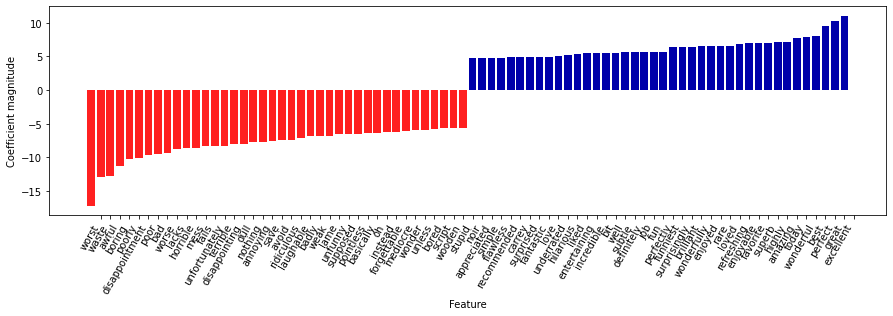

In [45]:
mglearn.tools.visualize_coefficients(
    grid.best_estimator_.named_steps['logisticregression'].coef_,
    feature_names,
    n_top_features=40)

*Largest and smallest coefficients of logistic regression trained on tf-idf features*

##  7.7 Bag-of-Words with More Than One Word (n-Grams)

In [46]:
print('bards_words:\n{}'.format(bards_words))

bards_words:
['The fool doth think he is wise,', 'but the wise man know himself to be a fool']


In [49]:
cv = CountVectorizer(ngram_range=(1, 1)).fit(bards_words)
print('Vocabulary size: {}'.format(len(cv.vocabulary_)))
print('Vocabulary:\n{}'.format(cv.get_feature_names_out()))

Vocabulary size: 13
Vocabulary:
['be' 'but' 'doth' 'fool' 'he' 'himself' 'is' 'know' 'man' 'the' 'think'
 'to' 'wise']


In [50]:
cv = CountVectorizer(ngram_range=(2, 2)).fit(bards_words)
print('Vocabulary size: {}'.format(len(cv.vocabulary_)))
print('Vocabulary:\n{}'.format(cv.get_feature_names_out()))

Vocabulary size: 14
Vocabulary:
['be fool' 'but the' 'doth think' 'fool doth' 'he is' 'himself to'
 'is wise' 'know himself' 'man know' 'the fool' 'the wise' 'think he'
 'to be' 'wise man']


In [51]:
print('Transformed data (dense):\n{}'.format(cv.transform(bards_words).toarray()))

Transformed data (dense):
[[0 0 1 1 1 0 1 0 0 1 0 1 0 0]
 [1 1 0 0 0 1 0 1 1 0 1 0 1 1]]


In [54]:
cv = CountVectorizer(ngram_range=(1, 3)).fit(bards_words)
print('Vocabulary size: {}'.format(len(cv.vocabulary_)))
print('Vocabulary:\n{}'.format(cv.get_feature_names_out()))

Vocabulary size: 39
Vocabulary:
['be' 'be fool' 'but' 'but the' 'but the wise' 'doth' 'doth think'
 'doth think he' 'fool' 'fool doth' 'fool doth think' 'he' 'he is'
 'he is wise' 'himself' 'himself to' 'himself to be' 'is' 'is wise' 'know'
 'know himself' 'know himself to' 'man' 'man know' 'man know himself'
 'the' 'the fool' 'the fool doth' 'the wise' 'the wise man' 'think'
 'think he' 'think he is' 'to' 'to be' 'to be fool' 'wise' 'wise man'
 'wise man know']


In [55]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression(n_jobs=-1))

# running the grid search takes a long time because of the
# relatively large grid and the inclusion of trigrams
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(text_train, y_train)

print('Best cross-validation score: {:.2f}'.format(grid.best_score_))
print('Best parameters:\n{}'.format(grid.best_params_))

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


KeyboardInterrupt: ignored

In [59]:
# extract scores from grid_search
scores = grid.cv_results_['mean_test_score'].reshape(-1, 3).T

# visualise heat map
heatmap = mglearn.tools.heatmap(
    scores, xlabel='C', ylabel='ngram_range', cmap='viridis', fmt='%.3f',
    xticklabels=param_grid['logisticregression__C'],
    yticklabels=param_grid['tfidfvectorizer__ngram_range'])

plt.colorbar();

AttributeError: ignored

*Heat map visualisation of mean cross-validation accuracy as a function of the parameters ngram_range and C*

In [60]:
# extract feature names and coefficients
vect = grid.best_estimator_.named_steps['tfidfvectorizer']
feature_names = np.array(vect.get_feature_names())
coef = grid.best_estimator_.named_steps['logisticregression'].coef_
mglearn.tools.visualize_coefficients(coef, feature_names, n_top_features=40)

AttributeError: ignored

*Most important features when using unigrams, bigrams, and trigrams with tf-idf rescaling*

In [61]:
# find trigram features
mask = np.array([len(feature.split(' ')) for feature in feature_names]) == 3

# visualise only trigram features
mglearn.tools.visualize_coefficients(coef.ravel()[mask],
                                     feature_names[mask], n_top_features=40)

NameError: ignored

*Visualisation of only the important trigram features of the model*

## 7.8 Advanced Tokenisation, Stemming, and Lemmatisation

In [62]:
# load spacy's English-language models
en_nlp = spacy.load('en')

# instantiate nltk's Porter stemmer
stemmer = nltk.stem.PorterStemmer()

# define function to compare lemmatisation in spacy with stemming in nltk
def compare_normalization(doc):
    # tokenize document in spacy
    doc_spacy = en_nlp(doc)
    # print lemmas found in spacy
    print('Lemmatization:')
    print([token.lemma_ for token in doc_spacy])
    # print tokens found by Porter stemmer
    print('Stemming:')
    print([stemmer.stem(token.norm_.lower()) for token in doc_spacy])

In [63]:
compare_normalization(u"Our meeting today was worse than yesterday, "
                        "I'm scared of meeting the clients tomorrow.")

Lemmatization:
['-PRON-', 'meeting', 'today', 'be', 'bad', 'than', 'yesterday', ',', '-PRON-', 'be', 'scared', 'of', 'meet', 'the', 'client', 'tomorrow', '.']
Stemming:
['our', 'meet', 'today', 'wa', 'wors', 'than', 'yesterday', ',', 'i', 'am', 'scare', 'of', 'meet', 'the', 'client', 'tomorrow', '.']


In [65]:
# Technicality: we want to use the regexp-based tokenizer
# that is used by CountVectorizer and only use the lemmatization
# from spacy. To this end, we replace en_nlp.tokenizer (the spacy tokenizer)
# with the regexp-based tokenization.

# regexp used in CountVectorizer
regexp = re.compile('(?u)\\b\\w\\w+\\b')

# load spacy language model
en_nlp = spacy.load('en', disable=['parser', 'ner'])
old_tokenizer = en_nlp.tokenizer

# replace the tokenizer with the preceding regexp
en_nlp.tokenizer = lambda string: old_tokenizer.tokens_from_list(
    regexp.findall(string))

# create a custom tokenizer using the spacy document processing pipeline
# (now using our own tokenizer)
def custom_tokenizer(document):
    doc_spacy = en_nlp(document)
    return [token.lemma_ for token in doc_spacy]

# define a count vectorizer with the custom tokenizer
lemma_vect = CountVectorizer(tokenizer=custom_tokenizer, min_df=5)

In [66]:
# transform text_train using CountVectorizer with lemmatization
X_train_lemma = lemma_vect.fit_transform(text_train)
print('X_train_lemma.shape: {}'.format(X_train_lemma.shape))

# standard CountVectorizer for reference
vect = CountVectorizer(min_df=5).fit(text_train)
X_train = vect.transform(text_train)
print('X_train.shape: {}'.format(X_train.shape))

X_train_lemma.shape: (25000, 21752)
X_train.shape: (25000, 27271)


In [69]:
# build a grid search using only 1% of the data as the training set
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.99,
                            train_size=0.01, random_state=0)

grid = GridSearchCV(LogisticRegression(max_iter=1000, n_jobs=-1), param_grid=param_grid, cv=cv, n_jobs=-1)

# perform grid search with standard CountVectorizer
grid.fit(X_train, y_train)
print('Best cross-validation score (Standard CountVectorizer): {:.3f}'.format(grid.best_score_))

# perform grid search with lemmatization
grid.fit(X_train_lemma, y_train)

print('Best cross-validation score (lemmatization): {:.3f}'.format(grid.best_score_))

Best cross-validation score (Standard CountVectorizer): 0.719
Best cross-validation score (lemmatization): 0.731


## 7.9 Topic Modelling and Document Clustering

### 7.9.1 Latent Dirichlet Allocation

* Tries to find groups of words (the topics) that appear together frequently.

* Requires that each document can be understood as a "mixture" of a subset of the topics.

In [70]:
vect = CountVectorizer(max_features=10000, max_df=0.15)
X = vect.fit_transform(text_train)

In [73]:
lda = LatentDirichletAllocation(n_components=10, learning_method='batch',
                                max_iter=25, random_state=0)

# we build the model and transform the data in one step
# computing transform takes some time,
# and we can save time by doing both at once
document_topics = lda.fit_transform(X)

In [74]:
print('lda.components_.shape: {}'.format(lda.components_.shape))

lda.components_.shape: (10, 10000)


In [75]:
# for each topic (a row in the components_), sort the features (ascending)
# invert rows with [:, ::-1] to make sorting descending
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]

# get the feature names from the vectorizer
feature_names = np.array(vect.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [76]:
# print out the 10 topics:
mglearn.tools.print_topics(topics=range(10), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
between       war           funny         show          didn          
young         world         worst         series        saw           
family        us            comedy        episode       am            
real          our           thing         tv            thought       
performance   american      guy           episodes      years         
beautiful     documentary   re            shows         book          
work          history       stupid        season        watched       
each          new           actually      new           now           
both          own           nothing       television    dvd           
director      point         want          years         got           


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
horr

In [77]:
lda100 = LatentDirichletAllocation(n_components=100, learning_method='batch',
                                   max_iter=25, random_state=0)

document_topics100 = lda100.fit_transform(X)

In [78]:
topics = np.array([7, 16, 24, 25, 28, 36, 37, 45, 51, 53, 54, 63, 89, 97])

sorting = np.argsort(lda100.components_, axis=1)[:, ::-1]
feature_names = np.array(vect.get_feature_names())

mglearn.tools.print_topics(topics=topics, feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=5, n_words=20)

topic 7       topic 16      topic 24      topic 25      topic 28      
--------      --------      --------      --------      --------      
thriller      worst         german        car           beautiful     
suspense      awful         hitler        gets          young         
horror        boring        nazi          guy           old           
atmosphere    horrible      midnight      around        romantic      
mystery       stupid        joe           down          between       
house         thing         germany       kill          romance       
director      terrible      years         goes          wonderful     
quite         script        history       killed        heart         
bit           nothing       new           going         feel          
de            worse         modesty       house         year          
performances  waste         cowboy        away          each          
dark          pretty        jewish        head          french        
twist 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [82]:
# sort by weight of "music" topic 45
music = np.argsort(document_topics100[:, 45])[::-1]

# print the five documents where the topic is most important
for i in music[:10]:
    print(b'.'.join(text_train[i].split(b'.')[:2]) + b'.\n')

b'I love this movie and never get tired of watching. The music in it is great.\n'
b"I enjoyed Still Crazy more than any film I have seen in years. A successful band from the 70's decide to give it another try.\n"
b'Hollywood Hotel was the last movie musical that Busby Berkeley directed for Warner Bros. His directing style had changed or evolved to the point that this film does not contain his signature overhead shots or huge production numbers with thousands of extras.\n'
b"What happens to washed up rock-n-roll stars in the late 1990's? They launch a comeback / reunion tour. At least, that's what the members of Strange Fruit, a (fictional) 70's stadium rock group do.\n"
b'As a big-time Prince fan of the last three to four years, I really can\'t believe I\'ve only just got round to watching "Purple Rain". The brand new 2-disc anniversary Special Edition led me to buy it.\n'
b"This film is worth seeing alone for Jared Harris' outstanding portrayal of John Lennon. It doesn't matter that H

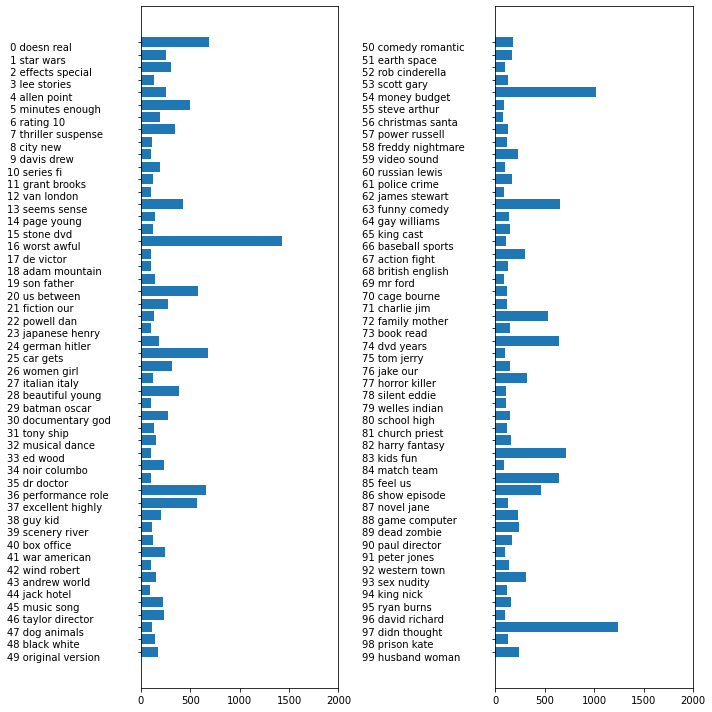

In [84]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
topic_names = ['{:>2} '.format(i) + ' '.join(words) for i, words in enumerate(feature_names[sorting][:, :2])]

# two column bar chart:
for col in [0, 1]:
    start= col * 50
    end = (col + 1) * 50
    ax[col].barh(np.arange(50), np.sum(document_topics100, axis=0)[start:end])
    ax[col].set_yticks(np.arange(50))
    ax[col].set_yticklabels(topic_names[start:end], ha='left', va='top')
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, 2000)
    yax = ax[col].get_yaxis()
    yax.set_tick_params(pad=130)

plt.tight_layout();

*Topics weights learning by LDA*